In [13]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from prettytable import PrettyTable
from numpy import expand_dims
!pip install keras_adabound
from keras_adabound import AdaBound
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, Callback, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [14]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
nb_layers = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [47]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 

In [25]:
# Normalize data.
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [5]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2, nb_layers=40):
    global compression
    temp = input
    for _ in range(nb_layers):
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

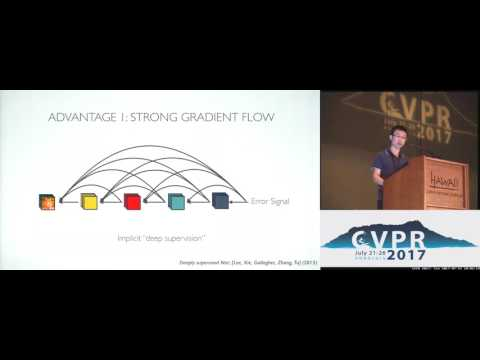

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,  validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 151s 386ms/step - loss: 1.7031 - accuracy: 0.3642 - val_loss: 1.7175 - val_accuracy: 0.4189
Epoch 2/10
391/391 [==============================] - 145s 371ms/step - loss: 1.2998 - accuracy: 0.5248 - val_loss: 1.5065 - val_accuracy: 0.5108
Epoch 3/10
391/391 [==============================] - 145s 371ms/step - loss: 1.1091 - accuracy: 0.6009 - val_loss: 1.1369 - val_accuracy: 0.6170
Epoch 4/10
391/391 [==============================] - 145s 371ms/step - loss: 1.0027 - accuracy: 0.6400 - val_loss: 1.9992 - val_accuracy: 0.4668
Epoch 5/10
391/391 [==============================] - 145s 371ms/step - loss: 0.9252 - accuracy: 0.6669 - val_loss: 1.0257 - val_accuracy: 0.6490
Epoch 6/10
391/391 [==============================] - 145s 371ms/step - loss: 0.8614 - accuracy: 0.6930 - val_loss: 1.1142 - val_accuracy: 0.6566
Epoch 7/10
391/391 [==============================] - 145s 371ms/step - loss: 0.8123 - accuracy: 0.7094 - val_loss: 1.3960 -

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 10s 32ms/step - loss: 0.8644 - accuracy: 0.7231
Test loss: 0.8644242882728577
Test accuracy: 0.7231000065803528


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [ ]:
final_tab = PrettyTable(['Augmentation','nb_layers','num_filters','compression','Optimizer','Test Accuracy'])
final_tab.add_row([None, nb_layers, num_filter, compression,'Adam',0.72])

In [ ]:
print(final_tab)

+--------------+-----------+-------------+-------------+-----------+---------------+
| Augmentation | nb_layers | num_filters | compression | Optimizer | Test Accuracy |
+--------------+-----------+-------------+-------------+-----------+---------------+
|     None     |     40    |      12     |     0.5     |    Adam   |      0.72     |
+--------------+-----------+-------------+-------------+-----------+---------------+


## Image Data Augmentation Techniques

In [ ]:
def dense_net(X_train, X_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 15, nb_layers = 20, num_filter=12, dropout_rate=0.2):
  
  #def decay_fn(epoch, lr):
  #  if epoch < 50:
  #    return 0.001
  #  elif epoch >= 50 and epoch < 75:
  #    return 0.0001
  #  else:
  #    return 0.00001

  #lr_scheduler = LearningRateScheduler(decay_fn)

  #csv_logger = CSVLogger('training.log')

  #checkpoint = ModelCheckpoint('gdrive/My Drive/cnnoncifar/models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
  #                                     verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  
  def select_optim():
    if opt=='adam':
      return Adam(learning_rate=lr)
    elif opt=='sgd':
      return SGD(learning_rate=lr)
    elif opt=='adabound':
      return AdaBound(lr=lr)

  input = layers.Input(shape=(img_height, img_width, channel,))
  First_Conv2D = layers.Conv2D(num_filter, kernel, use_bias=False ,padding='same')(input)

  First_Block = denseblock(First_Conv2D, num_filter, dropout_rate, nb_layers)
  First_Transition = transition(First_Block, num_filter, dropout_rate)

  Second_Block = denseblock(First_Transition, num_filter, dropout_rate, nb_layers)
  Second_Transition = transition(Second_Block, num_filter, dropout_rate)

  Third_Block = denseblock(Second_Transition, num_filter, dropout_rate, nb_layers)
  Third_Transition = transition(Third_Block, num_filter, dropout_rate)

  Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate, nb_layers)
  output = output_layer(Last_Block)

  #early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=5)

  model = Model(inputs=[input], outputs=[output])
         
  model.compile(optimizer=select_optim(), loss='categorical_crossentropy', metrics=['accuracy'])

  model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs,verbose=True,validation_data=(X_test, y_test))

  #model.fit_generator(datagen.flow(x_train, y_train, batch_size=b_size),steps_per_epoch=(len(xtrain)//batch_size)*5,epochs=epoch,
  #         verbose = 1,validation_data=(x_test, y_test),callbacks=[checkpoint])

  score = model.evaluate(X_test, y_test, verbose=1)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  return model

### Vertical and Horizontal Shift Augmentation:
A shift to an image means moving all pixels of the image in one direction, vertically,horizontally while keeping the image dimensions the same.

In [ ]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
def vertical_horizontal_shift(arr_imgs):
      # convert to numpy array
      d = arr_imgs.copy()
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(width_shift_range=[-10,10], height_shift_range=[-10,10])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d[i] = image
      return d

100%|██████████| 10000/10000 [00:04<00:00, 2204.14it/s]


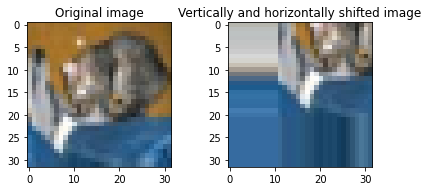

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[0])
plt.subplot(1,2,2)
plt.title('Vertically and horizontally shifted image')
plt.imshow(vertical_horizontal_shift(X_test)[0])
plt.tight_layout()

In [ ]:
vh_shift_train = vertical_horizontal_shift(X_train)
vh_shift_test  = vertical_horizontal_shift(X_test)

100%|██████████| 10000/10000 [00:04<00:00, 2146.42it/s]


In [ ]:
vh_flip_test.shape

(10000, 32, 32, 3)

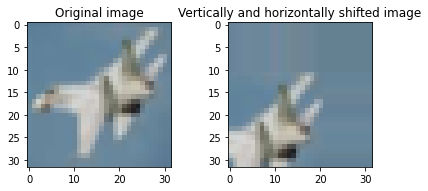

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[10])
plt.subplot(1,2,2)
plt.title('Vertically and horizontally shifted image')
plt.imshow(vh_shift_test[10])
plt.tight_layout()

### Densenet with Adam optimizer on vertically and horizontally shifted images

In [ ]:
dense_net(vh_shift_train, vh_shift_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 275s 703ms/step - loss: 2.3337 - accuracy: 0.1580 - val_loss: 2.0938 - val_accuracy: 0.1994
Epoch 2/12
391/391 [==============================] - 275s 704ms/step - loss: 1.9093 - accuracy: 0.2679 - val_loss: 2.0456 - val_accuracy: 0.2449
Epoch 3/12
391/391 [==============================] - 275s 703ms/step - loss: 1.6932 - accuracy: 0.3609 - val_loss: 1.8814 - val_accuracy: 0.3221
Epoch 4/12
391/391 [==============================] - 275s 703ms/step - loss: 1.4990 - accuracy: 0.4478 - val_loss: 3.4493 - val_accuracy: 0.2721
Epoch 5/12
391/391 [==============================] - 275s 703ms/step - loss: 1.3550 - accuracy: 0.5085 - val_loss: 2.0791 - val_accuracy: 0.4158
Epoch 6/12
391/391 [==============================] - 275s 703ms/step - loss: 1.2387 - accuracy: 0.5544 - val_loss: 1.6379 - val_accuracy: 0.4843
Epoch 7/12
391/391 [==============================] - 275s 702ms/step - loss: 1.1382 - accuracy: 0.5911 - val_loss: 2.0168 -

### Densenet with Adabound optimizer on vertically and horizontally shifted images

In [ ]:
dense_net(vh_shift_train, vh_shift_test, opt = 'adabound', kernel = (3,3), batch_size = 128, lr=0.001, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 289s 738ms/step - loss: 1.8660 - accuracy: 0.3074 - val_loss: 3.1546 - val_accuracy: 0.2322
Epoch 2/12
391/391 [==============================] - 288s 736ms/step - loss: 1.5167 - accuracy: 0.4402 - val_loss: 8.8488 - val_accuracy: 0.1349
Epoch 3/12
391/391 [==============================] - 288s 736ms/step - loss: 1.3179 - accuracy: 0.5214 - val_loss: 1.9477 - val_accuracy: 0.4313
Epoch 4/12
391/391 [==============================] - 288s 737ms/step - loss: 1.1897 - accuracy: 0.5726 - val_loss: 1.5785 - val_accuracy: 0.4830
Epoch 5/12
391/391 [==============================] - 288s 737ms/step - loss: 1.1000 - accuracy: 0.6071 - val_loss: 1.7649 - val_accuracy: 0.4934
Epoch 6/12
391/391 [==============================] - 288s 737ms/step - loss: 1.0354 - accuracy: 0.6297 - val_loss: 2.6802 - val_accuracy: 0.3621
Epoch 7/12
391/391 [==============================] - 288s 736ms/step - loss: 0.9885 - accuracy: 0.6483 - val_loss: 1.6025 -

### Horizontal and Vertical Flip Augmentation
An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.

In [ ]:
def vertical_horizontal_flip(arr_imgs):
      # convert to numpy array
      d = arr_imgs.copy()
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(vertical_flip=True, horizontal_flip=True)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d[i] = image
      return d

100%|██████████| 10000/10000 [00:01<00:00, 9313.15it/s]


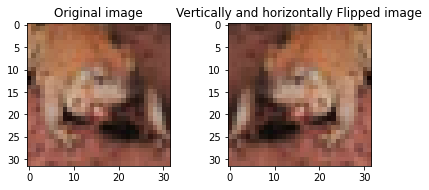

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[5])
plt.subplot(1,2,2)
plt.title('Vertically and horizontally Flipped image')
plt.imshow(vertical_horizontal_flip(X_test)[5])
plt.tight_layout()

In [ ]:
vh_flip_train = vertical_horizontal_flip(X_train)
vh_flip_test  = vertical_horizontal_flip(X_test)

100%|██████████| 10000/10000 [00:00<00:00, 10641.68it/s]


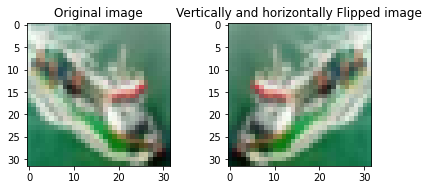

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[15])
plt.subplot(1,2,2)
plt.title('Vertically and horizontally Flipped image')
plt.imshow(vh_flip_test[15])
plt.tight_layout()

### Densenet with Adam optimizer on vertically and horizontally Flipped images

In [ ]:
dense_net(vh_flip_train, vh_flip_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 217s 556ms/step - loss: 1.9346 - accuracy: 0.2908 - val_loss: 4.4718 - val_accuracy: 0.1934
Epoch 2/12
391/391 [==============================] - 216s 554ms/step - loss: 1.4729 - accuracy: 0.4486 - val_loss: 3.0216 - val_accuracy: 0.2564
Epoch 3/12
391/391 [==============================] - 216s 553ms/step - loss: 1.2334 - accuracy: 0.5483 - val_loss: 1.8416 - val_accuracy: 0.4841
Epoch 4/12
391/391 [==============================] - 216s 553ms/step - loss: 1.0731 - accuracy: 0.6085 - val_loss: 1.2015 - val_accuracy: 0.6090
Epoch 5/12
391/391 [==============================] - 216s 553ms/step - loss: 0.9708 - accuracy: 0.6477 - val_loss: 1.9949 - val_accuracy: 0.4786
Epoch 6/12
391/391 [==============================] - 216s 553ms/step - loss: 0.9033 - accuracy: 0.6729 - val_loss: 1.7528 - val_accuracy: 0.4929
Epoch 7/12
391/391 [==============================] - 216s 553ms/step - loss: 0.8422 - accuracy: 0.6953 - val_loss: 1.4749 -

### Densenet with Adabound optimizer on vertically and horizontally Flipped images

In [ ]:
dense_net(vh_flip_train, vh_flip_test, opt = 'adabound', kernel = (3,3), batch_size = 128, lr=0.001, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 258s 661ms/step - loss: 1.6296 - accuracy: 0.3878 - val_loss: 1.7738 - val_accuracy: 0.4110
Epoch 2/12
391/391 [==============================] - 253s 647ms/step - loss: 1.2670 - accuracy: 0.5372 - val_loss: 1.4856 - val_accuracy: 0.5099
Epoch 3/12
391/391 [==============================] - 253s 648ms/step - loss: 1.1068 - accuracy: 0.5994 - val_loss: 1.2882 - val_accuracy: 0.5616
Epoch 4/12
391/391 [==============================] - 253s 647ms/step - loss: 1.0114 - accuracy: 0.6341 - val_loss: 2.2347 - val_accuracy: 0.4634
Epoch 5/12
391/391 [==============================] - 253s 646ms/step - loss: 0.9431 - accuracy: 0.6601 - val_loss: 1.3578 - val_accuracy: 0.5498
Epoch 6/12
391/391 [==============================] - 253s 647ms/step - loss: 0.8916 - accuracy: 0.6783 - val_loss: 1.5357 - val_accuracy: 0.5527
Epoch 7/12
391/391 [==============================] - 253s 647ms/step - loss: 0.8517 - accuracy: 0.6907 - val_loss: 1.1109 -


### Random Rotation Augmentation
A rotation augmentation randomly rotates the image clockwise by a given number of degrees from 0 to 360.


In [ ]:
def rotated_image(arr_imgs):
      # convert to numpy array
      d = arr_imgs.copy()
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(rotation_range=15)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d[i] = image
      return d

100%|██████████| 10000/10000 [00:04<00:00, 2369.03it/s]


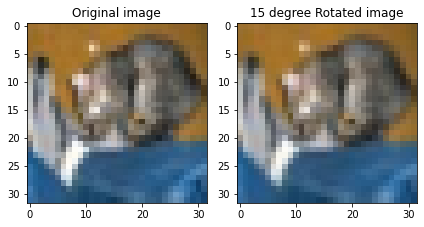

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[0])
plt.subplot(1,2,2)
plt.title('15 degree Rotated image')
plt.imshow(rotated_image(X_test)[0])
plt.tight_layout()

In [ ]:
rotate_train = rotated_image(X_train)
rotate_test  = rotated_image(X_test)

100%|██████████| 10000/10000 [00:04<00:00, 2326.53it/s]


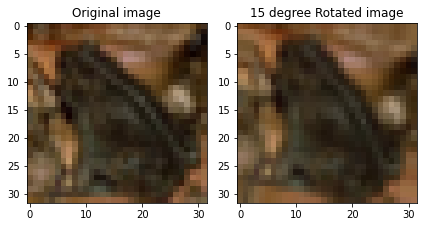

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[30])
plt.subplot(1,2,2)
plt.title('15 degree Rotated image')
plt.imshow(rotate_test[30])
plt.tight_layout()

### Densenet with Adam optimizer on Randomly rotated images

In [ ]:
dense_net(rotate_train, rotate_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 63s 161ms/step - loss: 1.8779 - accuracy: 0.3236 - val_loss: 4.0309 - val_accuracy: 0.1552
Epoch 2/12
391/391 [==============================] - 61s 155ms/step - loss: 1.4151 - accuracy: 0.4840 - val_loss: 2.5786 - val_accuracy: 0.3451
Epoch 3/12
391/391 [==============================] - 61s 155ms/step - loss: 1.1946 - accuracy: 0.5683 - val_loss: 1.2218 - val_accuracy: 0.5737
Epoch 4/12
391/391 [==============================] - 61s 155ms/step - loss: 1.0302 - accuracy: 0.6337 - val_loss: 1.3006 - val_accuracy: 0.5735
Epoch 5/12
391/391 [==============================] - 61s 155ms/step - loss: 0.9116 - accuracy: 0.6772 - val_loss: 1.0195 - val_accuracy: 0.6549
Epoch 6/12
391/391 [==============================] - 61s 155ms/step - loss: 0.8301 - accuracy: 0.7059 - val_loss: 0.9213 - val_accuracy: 0.6939
Epoch 7/12
391/391 [==============================] - 60s 155ms/step - loss: 0.7648 - accuracy: 0.7314 - val_loss: 0.9917 - val_ac

### Densenet with Adabound optimizer on Randomly rotated images

In [ ]:
dense_net(rotate_train, rotate_test, opt = 'adabound', kernel = (3,3), batch_size = 128, lr=0.001, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 74s 190ms/step - loss: 1.5189 - accuracy: 0.4405 - val_loss: 1.4979 - val_accuracy: 0.4760
Epoch 2/12
391/391 [==============================] - 73s 188ms/step - loss: 1.1511 - accuracy: 0.5836 - val_loss: 1.3897 - val_accuracy: 0.5422
Epoch 3/12
391/391 [==============================] - 73s 188ms/step - loss: 1.0109 - accuracy: 0.6360 - val_loss: 1.4037 - val_accuracy: 0.5598
Epoch 4/12
391/391 [==============================] - 73s 187ms/step - loss: 0.9240 - accuracy: 0.6696 - val_loss: 1.1181 - val_accuracy: 0.6306
Epoch 5/12
391/391 [==============================] - 73s 188ms/step - loss: 0.8578 - accuracy: 0.6945 - val_loss: 0.9066 - val_accuracy: 0.6979
Epoch 6/12
391/391 [==============================] - 73s 188ms/step - loss: 0.7968 - accuracy: 0.7195 - val_loss: 1.0753 - val_accuracy: 0.6585
Epoch 7/12
391/391 [==============================] - 74s 189ms/step - loss: 0.7456 - accuracy: 0.7366 - val_loss: 1.2120 - val_ac

### Random Brightness Augmentation
The brightness of the image can be augmented by either randomly darkening images, brightening images, or both.

In [ ]:
def brightness_aug(arr_imgs):
      # convert to numpy array
      d = arr_imgs.copy()
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(brightness_range=[0.4,0.6])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d[i] = image
      return d

100%|██████████| 10000/10000 [00:03<00:00, 3192.19it/s]


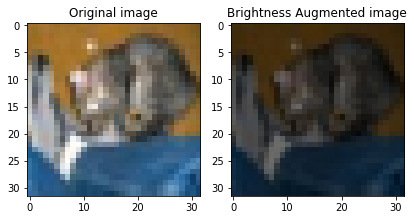

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[0])
plt.subplot(1,2,2)
plt.title('Brightness Augmented image')
plt.imshow(brightness_aug(X_test)[0])
plt.tight_layout()

In [ ]:
brightness_train = brightness_aug(X_train)
brightness_test  = brightness_aug(X_test)

100%|██████████| 10000/10000 [00:03<00:00, 3172.45it/s]


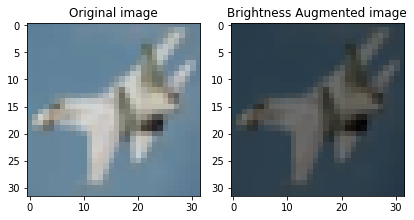

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[10])
plt.subplot(1,2,2)
plt.title('Brightness Augmented image')
plt.imshow(brightness_test[10])
plt.tight_layout()

### Densenet with Adam optimizer on brightness augmented images

In [ ]:
dense_net(brightness_train, brightness_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 217s 556ms/step - loss: 1.9291 - accuracy: 0.3013 - val_loss: 3.3891 - val_accuracy: 0.1982
Epoch 2/12
391/391 [==============================] - 216s 553ms/step - loss: 1.4464 - accuracy: 0.4679 - val_loss: 2.2578 - val_accuracy: 0.3819
Epoch 3/12
391/391 [==============================] - 216s 552ms/step - loss: 1.1569 - accuracy: 0.5807 - val_loss: 1.4491 - val_accuracy: 0.5449
Epoch 4/12
391/391 [==============================] - 216s 553ms/step - loss: 0.9697 - accuracy: 0.6517 - val_loss: 1.1990 - val_accuracy: 0.6183
Epoch 5/12
391/391 [==============================] - 216s 553ms/step - loss: 0.8517 - accuracy: 0.6961 - val_loss: 1.5730 - val_accuracy: 0.5499
Epoch 6/12
391/391 [==============================] - 216s 553ms/step - loss: 0.7829 - accuracy: 0.7220 - val_loss: 1.0720 - val_accuracy: 0.6393
Epoch 7/12
391/391 [==============================] - 216s 553ms/step - loss: 0.7178 - accuracy: 0.7456 - val_loss: 0.9923 -

### Densenet with Adabound optimizer on brightness augmented images

In [ ]:
dense_net(brightness_train, brightness_test, opt = 'adabound', kernel = (3,3), batch_size = 128, lr=0.001, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 254s 651ms/step - loss: 1.5354 - accuracy: 0.4341 - val_loss: 1.8016 - val_accuracy: 0.4218
Epoch 2/12
391/391 [==============================] - 254s 649ms/step - loss: 1.1352 - accuracy: 0.5904 - val_loss: 1.5769 - val_accuracy: 0.4941
Epoch 3/12
391/391 [==============================] - 254s 649ms/step - loss: 0.9739 - accuracy: 0.6515 - val_loss: 1.8927 - val_accuracy: 0.5198
Epoch 4/12
391/391 [==============================] - 254s 650ms/step - loss: 0.8691 - accuracy: 0.6878 - val_loss: 1.1923 - val_accuracy: 0.6290
Epoch 5/12
391/391 [==============================] - 254s 650ms/step - loss: 0.8054 - accuracy: 0.7118 - val_loss: 0.8941 - val_accuracy: 0.6966
Epoch 6/12
391/391 [==============================] - 254s 649ms/step - loss: 0.7486 - accuracy: 0.7351 - val_loss: 0.9974 - val_accuracy: 0.6899
Epoch 7/12
391/391 [==============================] - 253s 647ms/step - loss: 0.7057 - accuracy: 0.7496 - val_loss: 0.8454 -

### Random Zoom Augmentation
A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.

In [ ]:
def zoom_img(arr_imgs):
      # convert to numpy array
      d = arr_imgs.copy()
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(zoom_range = 0.3)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d[i] = image
      return d

100%|██████████| 10000/10000 [00:05<00:00, 1752.91it/s]


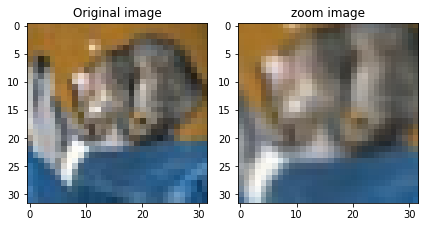

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[0])
plt.subplot(1,2,2)
plt.title('zoom image')
plt.imshow(zoom_img(X_test)[0])
plt.tight_layout()

In [ ]:
zoom_train = zoom_img(X_train)
zoom_test  = zoom_img(X_test)

100%|██████████| 10000/10000 [00:05<00:00, 1748.68it/s]


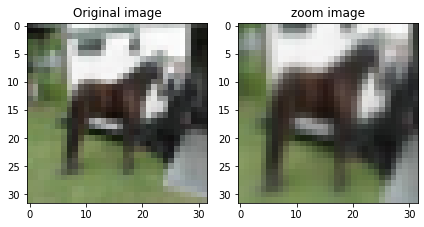

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[20])
plt.subplot(1,2,2)
plt.title('zoom image')
plt.imshow(zoom_test[20])
plt.tight_layout()

### Densenet with Adam optimizer on zoom augmented images

In [ ]:
dense_net(zoom_train, zoom_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 217s 555ms/step - loss: 1.9448 - accuracy: 0.3022 - val_loss: 2.9470 - val_accuracy: 0.2425
Epoch 2/12
391/391 [==============================] - 216s 553ms/step - loss: 1.5024 - accuracy: 0.4537 - val_loss: 1.7987 - val_accuracy: 0.4300
Epoch 3/12
391/391 [==============================] - 216s 553ms/step - loss: 1.2941 - accuracy: 0.5345 - val_loss: 1.4026 - val_accuracy: 0.5100
Epoch 4/12
391/391 [==============================] - 216s 553ms/step - loss: 1.1311 - accuracy: 0.5976 - val_loss: 1.6361 - val_accuracy: 0.4574
Epoch 5/12
391/391 [==============================] - 216s 553ms/step - loss: 1.0149 - accuracy: 0.6384 - val_loss: 2.1997 - val_accuracy: 0.4788
Epoch 6/12
391/391 [==============================] - 216s 553ms/step - loss: 0.9173 - accuracy: 0.6736 - val_loss: 1.6966 - val_accuracy: 0.5446
Epoch 7/12
391/391 [==============================] - 216s 553ms/step - loss: 0.8392 - accuracy: 0.7046 - val_loss: 1.4952 -

### Densenet with Adabound optimizer on zoom augmented images

In [ ]:
dense_net(zoom_train, zoom_test, opt = 'adabound', kernel = (3,3), batch_size = 128, lr=0.001, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 254s 651ms/step - loss: 1.6096 - accuracy: 0.4108 - val_loss: 1.5132 - val_accuracy: 0.4600
Epoch 2/12
391/391 [==============================] - 253s 646ms/step - loss: 1.2751 - accuracy: 0.5391 - val_loss: 2.1127 - val_accuracy: 0.3542
Epoch 3/12
391/391 [==============================] - 253s 648ms/step - loss: 1.1112 - accuracy: 0.6007 - val_loss: 1.2096 - val_accuracy: 0.5697
Epoch 4/12
391/391 [==============================] - 253s 647ms/step - loss: 1.0037 - accuracy: 0.6421 - val_loss: 1.2303 - val_accuracy: 0.6034
Epoch 5/12
391/391 [==============================] - 254s 650ms/step - loss: 0.9192 - accuracy: 0.6719 - val_loss: 1.3056 - val_accuracy: 0.6033
Epoch 6/12
391/391 [==============================] - 253s 648ms/step - loss: 0.8565 - accuracy: 0.6940 - val_loss: 1.2001 - val_accuracy: 0.6219
Epoch 7/12
391/391 [==============================] - 253s 648ms/step - loss: 0.8086 - accuracy: 0.7137 - val_loss: 0.9756 -

### Feature Standardization

In [ ]:
def features_standardized(arr_imgs):
      # convert to numpy array
      d = arr_imgs.copy()
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d[i] = image
      return d

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████| 10000/10000 [00:00<00:00, 10156.94it/s]


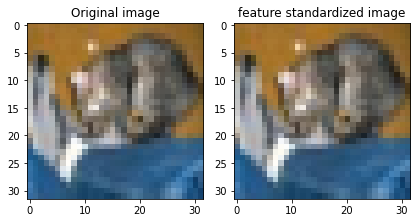

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[0])
plt.subplot(1,2,2)
plt.title('feature standardized image')
plt.imshow(features_standardized(X_test)[0])
plt.tight_layout()

In [ ]:
features_std_train = features_standardized(X_train)
features_std_test  = features_standardized(X_test)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████| 10000/10000 [00:00<00:00, 10184.20it/s]


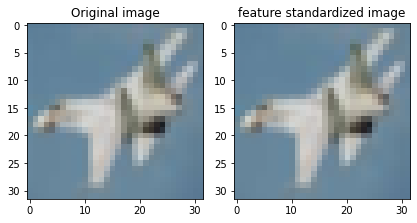

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(X_test[10])
plt.subplot(1,2,2)
plt.title('feature standardized image')
plt.imshow(features_std_test[10])
plt.tight_layout()

In [ ]:
dense_net(features_std_train, features_std_test, opt = 'adam', kernel = (3,3), batch_size = 128, lr=0.01, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 217s 555ms/step - loss: 1.9040 - accuracy: 0.3162 - val_loss: 3.9638 - val_accuracy: 0.1742
Epoch 2/12
391/391 [==============================] - 216s 553ms/step - loss: 1.3566 - accuracy: 0.5072 - val_loss: 1.7760 - val_accuracy: 0.4383
Epoch 3/12
391/391 [==============================] - 216s 553ms/step - loss: 1.0746 - accuracy: 0.6158 - val_loss: 1.2777 - val_accuracy: 0.5916
Epoch 4/12
391/391 [==============================] - 216s 553ms/step - loss: 0.9234 - accuracy: 0.6698 - val_loss: 1.1222 - val_accuracy: 0.6154
Epoch 5/12
391/391 [==============================] - 216s 553ms/step - loss: 0.8229 - accuracy: 0.7068 - val_loss: 1.2144 - val_accuracy: 0.6238
Epoch 6/12
391/391 [==============================] - 216s 553ms/step - loss: 0.7431 - accuracy: 0.7361 - val_loss: 0.9702 - val_accuracy: 0.6788
Epoch 7/12
391/391 [==============================] - 216s 553ms/step - loss: 0.6750 - accuracy: 0.7632 - val_loss: 0.8837 -

In [ ]:
dense_net(features_std_train, features_std_test, opt = 'adabound', kernel = (3,3), batch_size = 128, lr=0.001, epochs = 12, nb_layers = 14, num_filter=32, dropout_rate=0.2)

Epoch 1/12
391/391 [==============================] - 254s 648ms/step - loss: 1.4655 - accuracy: 0.4617 - val_loss: 1.8882 - val_accuracy: 0.4257
Epoch 2/12
391/391 [==============================] - 252s 646ms/step - loss: 1.0697 - accuracy: 0.6142 - val_loss: 1.3740 - val_accuracy: 0.5629
Epoch 3/12
391/391 [==============================] - 253s 646ms/step - loss: 0.9261 - accuracy: 0.6671 - val_loss: 1.1422 - val_accuracy: 0.6133
Epoch 4/12
391/391 [==============================] - 252s 645ms/step - loss: 0.8359 - accuracy: 0.7018 - val_loss: 0.9278 - val_accuracy: 0.6826
Epoch 5/12
391/391 [==============================] - 252s 646ms/step - loss: 0.7657 - accuracy: 0.7264 - val_loss: 1.4296 - val_accuracy: 0.5995
Epoch 6/12
391/391 [==============================] - 253s 647ms/step - loss: 0.7134 - accuracy: 0.7461 - val_loss: 1.2363 - val_accuracy: 0.6361
Epoch 7/12
391/391 [==============================] - 253s 646ms/step - loss: 0.6650 - accuracy: 0.7660 - val_loss: 1.0672 -

In [19]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Adam = 'Adam'
Adabound = 'Adabound'

x = PrettyTable()
x.title = "Image Augmentation Techniques Comparison"
x.field_names = ["Augmentation", "nb_layers",'num_filters',"Optimizer","Accuracy"]
x.add_row(["Vertically and Horizontally shifted",14,32,Adam, 54.42])
x.add_row(["Vertically and Horizontally shifted",14,32,Adabound, 63.44])
x.add_row(['','','','',''])
x.add_row(["Vertically and Horizontally flipped",14,32,Adam, 61.68])
x.add_row(["Vertically and Horizontally flipped",14,32,Adabound, 67.77])
x.add_row(['','','','',''])
x.add_row(["Random Rotation Augmentation",14,32,Adam, 74.66])
x.add_row(["Random Rotaion Augmentation",14,32,Adabound, 76.94])
x.add_row(['','','','',''])
x.add_row(["Random Brightness Augmentation",14,32,Adam, 76.56])
x.add_row(["Random Brightness Augmentation",14,32,Adabound, 77.05])
x.add_row(['','','','',''])
x.add_row(["Random Zoom Augmentation",14,32,Adam, 73.83])
x.add_row(["Random Zoom Augmentation",14,32,Adabound, 75.59])
x.add_row(['','','','',''])
x.add_row(["Feature Standardization",14,32,Adam, 78.42])
x.add_row(["Feature Standardization",14,32,Adabound, 77.18])

print(x)

+--------------------------------------------------------------------------------------+
|                       Image Augmentation Techniques Comparison                       |
+-------------------------------------+-----------+-------------+-----------+----------+
|             Augmentation            | nb_layers | num_filters | Optimizer | Accuracy |
+-------------------------------------+-----------+-------------+-----------+----------+
| Vertically and Horizontally shifted |     14    |      32     |    Adam   |  54.42   |
| Vertically and Horizontally shifted |     14    |      32     |  Adabound |  63.44   |
|                                     |           |             |           |          |
| Vertically and Horizontally flipped |     14    |      32     |    Adam   |  61.68   |
| Vertically and Horizontally flipped |     14    |      32     |  Adabound |  67.77   |
|                                     |           |             |           |          |
|     Random Rotation

__We will select the image data augmentation techniques which influence the test accuracy highly__ 

__Techniques with high test accuracy such as feature standardization, zoom augmentation, Rotation Augmentation, etc. will be used to build the final Densenet model__ 